In [1]:
"""
Establishing baseline embedding / sim search performance with DINOv2 (Avg Patch Embeddings)
@File    : baseline_avg.ipynb
@Date    : 2026-01-11
@Author  : Nandini Bohra
@Contact : nbohra@ucsd.edu
"""

'\nEstablishing baseline embedding / sim search performance with DINOv2 (Avg Patch Embeddings)\n@File    : baseline_avg.ipynb\n@Date    : 2026-01-11\n@Author  : Nandini Bohra\n@Contact : nbohra@ucsd.edu\n'

In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd

In [3]:
payloads = pd.read_csv("payloads.csv")

In [4]:
# Baseline trials with DINOv2 model
from transformers import AutoImageProcessor, AutoModel
import torch

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model.eval()

/Users/nandinibohra/Desktop/VSCodeFiles/ImageRecommendation_ProductMatching/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06,

#### Extraction of embeddings based on pooling approach

In [5]:
# Patch: e.g. 518 x 518 input image --> divided in 14x14 patches --> 37x37 = 1369 patches + 1 CLS token
# Each patch is embedded by vec of dim 768 

# Average pooling == Average 1369 embeddings into 1 dim768 embedding


# Baseline #1: Extract average patch embeddings
def get_avg_dinov2(img_path):
    image = Image.open(img_path).convert('RGB')
    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # Removing CLS Token and taking average of all patch embeddings
    # This is because CLS token is used for classification, semantics and not for image embeddings
    # Proceeding with average of all patch embeddings to retain more fine-grained details of image

    patches = outputs.last_hidden_state[:, 1:, :] # Grab all patch embeddings, no CLS token
    avg_patch_emb = torch.mean(patches, dim=1)

    avg_patch_emb = avg_patch_emb / avg_patch_emb.norm(dim=-1, keepdim=True)

    return avg_patch_emb.squeeze(0).numpy()

# Baseline #2: Extract CLS embedding (1st embedding in hidden states)

def get_cls_dinov2(img_path):
    image = Image.open(img_path).convert('RGB')
    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    cls = outputs.last_hidden_state[:, 0,:]
    # print(cls.shape)

    # Normalize embedding
    norm_emb = cls / cls.norm(dim=-1, keepdim=True)

    return norm_emb.squeeze(0).numpy()

#### Generation of embeddings

In [6]:
avg_embeddings = []
for img_path in payloads["image_url"]:
    emb = get_avg_dinov2(img_path)
    avg_embeddings.append(emb)

avg_embeddings = np.array(avg_embeddings)
print(f"AVG Embeddings shape: {avg_embeddings.shape}")

AVG Embeddings shape: (50, 768)


In [7]:
cls_embeddings = []
for img_path in payloads["image_url"]:
    emb = get_cls_dinov2(img_path)
    cls_embeddings.append(emb)

cls_embeddings = np.array(cls_embeddings)
print(f"CLS Embeddings shape: {cls_embeddings.shape}")

CLS Embeddings shape: (50, 768)


#### Assessing similarity scores on baseline embeddings

In [8]:
# Get sim mat for both baseline approaches
avg_similarity_matrix = cosine_similarity(avg_embeddings)
cls_similarity_matrix = cosine_similarity(cls_embeddings)

In [ ]:
upper_tri_indices = np.triu_indices_from(avg_similarity_matrix, k=1)

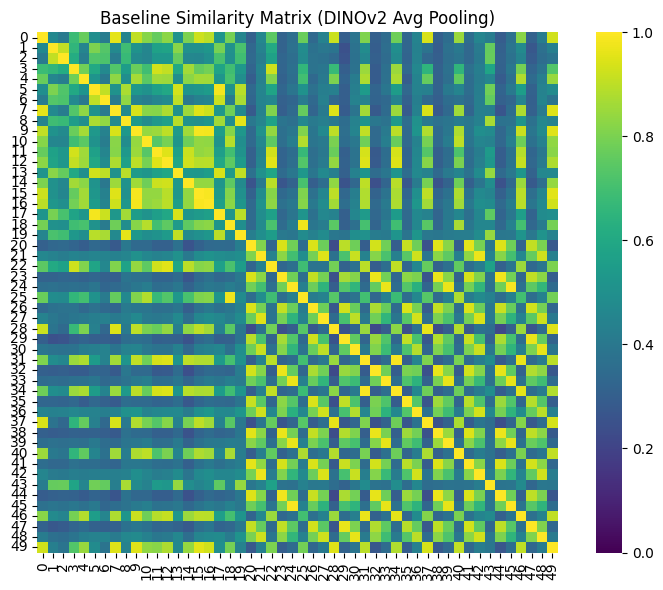

In [9]:
# Plot AVG sim mat
plt.figure(figsize=(8, 6))
sns.heatmap(
    avg_similarity_matrix,
    xticklabels=payloads["id"],
    yticklabels=payloads["id"],
    cmap='viridis',
    vmin=0, vmax=1,
    square=True
)
plt.title('Baseline Similarity Matrix (DINOv2 Avg Pooling)')
plt.tight_layout()
# plt.savefig('baseline_similarity_matrix.png')
plt.show()


Similarity Statistics:
  Mean: 0.549
  Std:  0.222
  Min:  0.218
  Max:  0.992


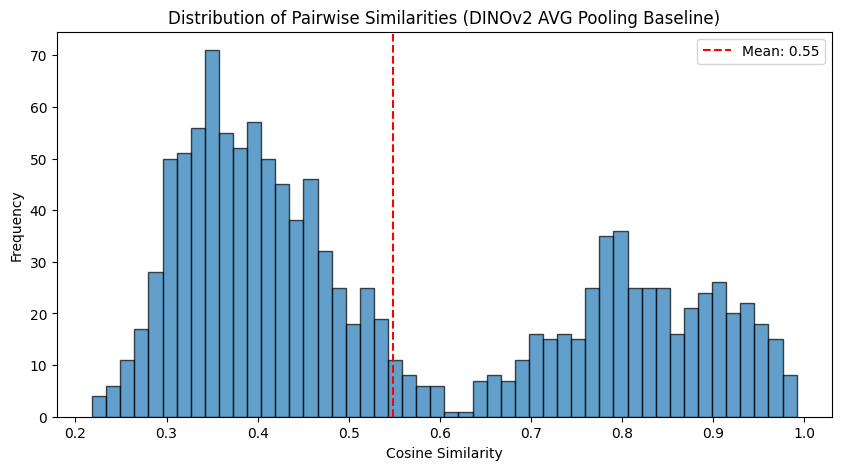

In [ ]:
# Get distribution of similarity scores for AVG pooling baseline

avg_similarities = avg_similarity_matrix[upper_tri_indices]

print("\nSimilarity Statistics:")
print(f"  Mean: {avg_similarities.mean():.3f}")
print(f"  Std:  {avg_similarities.std():.3f}")
print(f"  Min:  {avg_similarities.min():.3f}")
print(f"  Max:  {avg_similarities.max():.3f}")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(avg_similarities, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(avg_similarities.mean(), color='red', linestyle='--', label=f'Mean: {avg_similarities.mean():.2f}')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Similarities (DINOv2 AVG Pooling Baseline)')
plt.legend()
# plt.savefig('baseline_distribution.png')
plt.show()

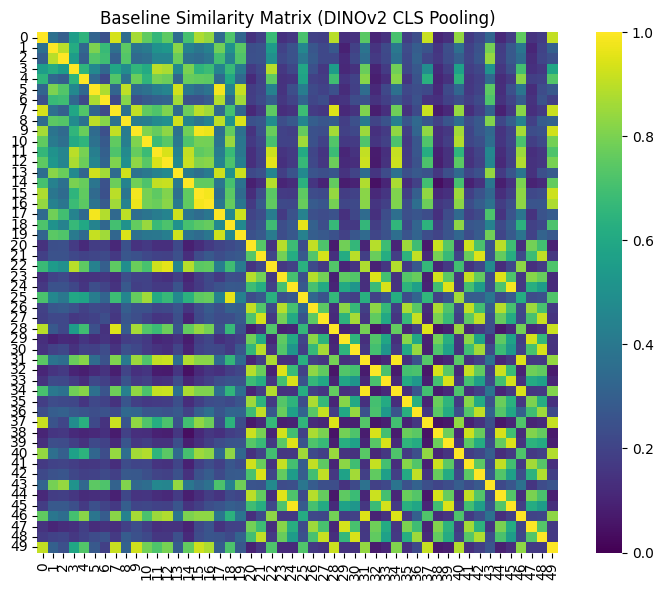

In [12]:
# Plot CLS sim mat
plt.figure(figsize=(8, 6))
sns.heatmap(
    cls_similarity_matrix,
    xticklabels=payloads["id"],
    yticklabels=payloads["id"],
    cmap='viridis',
    vmin=0, vmax=1,
    square=True
)
plt.title('Baseline Similarity Matrix (DINOv2 CLS Pooling)')
plt.tight_layout()
# plt.savefig('baseline_similarity_matrix.png')
plt.show()


Similarity Statistics:
  Mean: 0.418
  Std:  0.279
  Min:  0.039
  Max:  0.991


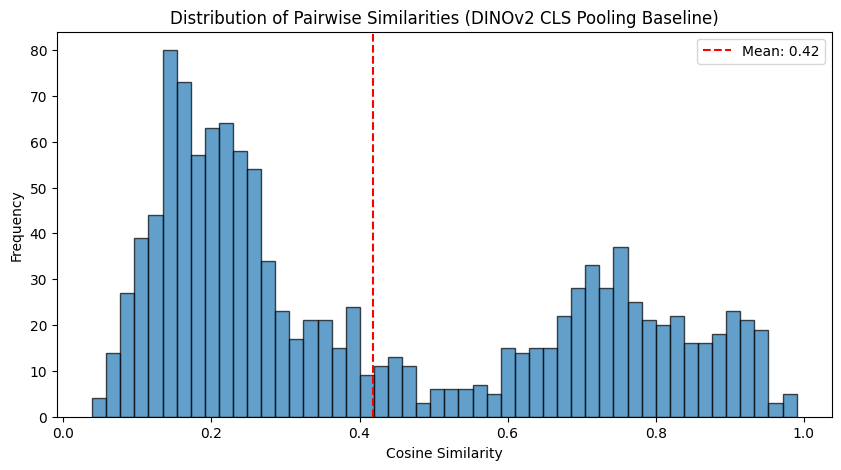

In [ ]:
# Get distribution of similarity scores for CLS pooling baseline

cls_similarities = cls_similarity_matrix[upper_tri_indices]

print("\nSimilarity Statistics:")
print(f"  Mean: {cls_similarities.mean():.3f}")
print(f"  Std:  {cls_similarities.std():.3f}")
print(f"  Min:  {cls_similarities.min():.3f}")
print(f"  Max:  {cls_similarities.max():.3f}")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(cls_similarities, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(cls_similarities.mean(), color='red', linestyle='--', label=f'Mean: {cls_similarities.mean():.2f}')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Similarities (DINOv2 CLS Pooling Baseline)')
plt.legend()
# plt.savefig('baseline_distribution.png')
plt.show()

Notice the valley in both distributions. There are groups of very similar textiles and groups of very dissimilar textiles. Delving further into this separation.

In [ ]:
materials = payloads["material"]
colors = payloads["color"]

In [19]:
# Trying to understand the bimodal distributions above
# Why certain similarity 'buckets'?
pair_indices = list(zip(upper_tri_indices[0], upper_tri_indices[1]))

# For AVG pooling
avg_similarities = avg_similarity_matrix[upper_tri_indices]

# Split into low and high similarity groups
avg_threshold = 0.6  # Valley happens around 0.6 in AVG baseline
avg_low_sim_pairs = [(i, j) for (i, j), sim in zip(pair_indices, avg_similarities) if sim < avg_threshold]
avg_high_sim_pairs = [(i, j) for (i, j), sim in zip(pair_indices, avg_similarities) if sim >= avg_threshold]



# For CLS pooling
cls_similarities = cls_similarity_matrix[upper_tri_indices]

# Split into low and high similarity groups
cls_threshold = 0.5  # Valley happens around 0.5 in CLS baseline
cls_low_sim_pairs = [(i, j) for (i, j), sim in zip(pair_indices, cls_similarities) if sim < cls_threshold]
cls_high_sim_pairs = [(i, j) for (i, j), sim in zip(pair_indices, cls_similarities) if sim >= cls_threshold]


print("AVG POOLING: HIGH vs. LOW SIMILARITY GROUPS")
print("-"*50)
print(f"Low similarity pairs (<{avg_threshold}): {len(avg_low_sim_pairs)}")
print(f"High similarity pairs (≥{avg_threshold}): {len(avg_high_sim_pairs)}")
print()

print("="*50)
print()

print("CLS POOLING: HIGH vs. LOW SIMILARITY GROUPS")
print("-"*50)
print(f"Low similarity pairs (<{cls_threshold}): {len(cls_low_sim_pairs)}")
print(f"High similarity pairs (≥{cls_threshold}): {len(cls_high_sim_pairs)}")

AVG POOLING: HIGH vs. LOW SIMILARITY GROUPS
--------------------------------------------------
Low similarity pairs (<0.6): 785
High similarity pairs (≥0.6): 440


CLS POOLING: HIGH vs. LOW SIMILARITY GROUPS
--------------------------------------------------
Low similarity pairs (<0.5): 781
High similarity pairs (≥0.5): 444
